In [ ]:
!pip install pennylane


  Using cached pennylane-0.44.0-py3-none-any.whl.metadata (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 114.6 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


In [ ]:
# Make moons
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)
y = np.where(y == 0, -1, 1)  # QNN için {-1, +1}

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Torch tensor format (MLP)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor((y_train+1)//2, dtype=torch.float32).unsqueeze(1)  # {0,1} MLP
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor((y_test+1)//2, dtype=torch.float32).unsqueeze(1)


In [ ]:
# Simple MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Model, optimizer, loss
mlp = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

# Training
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:02d} | Loss: {loss.item():.4f}")

# Test
with torch.no_grad():
    y_pred = mlp(X_test_t).round()
acc = (y_pred.eq(y_test_t).sum().item()) / len(y_test_t)
print(f"MLP Test Accuracy: {acc:.3f}")


Epoch 00 | Loss: 0.7828
Epoch 20 | Loss: 0.5479
Epoch 40 | Loss: 0.3807
Epoch 60 | Loss: 0.3242
Epoch 80 | Loss: 0.3013
MLP Test Accuracy: 0.900


Eğitim başladı (Data Re-uploading aktif)...
Epoch 00 | Loss: 1.1128
Epoch 10 | Loss: 0.7558
Epoch 20 | Loss: 0.6190
Epoch 30 | Loss: 0.5622
Epoch 40 | Loss: 0.5300
Epoch 50 | Loss: 0.5024

Final Test Accuracy: 0.975


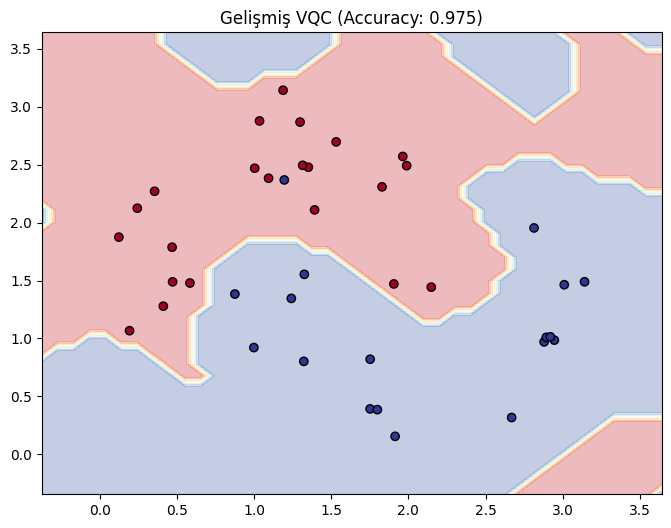

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ==========================================
# 1. Veri Hazırlığı (Daha Optimize)
# ==========================================
X, y = make_moons(n_samples=200, noise=0.15, random_state=42)
y = y * 2 - 1  # -1 ve 1 formatı

# Veriyi [0, pi] arasına çekmek kuantum kapıları için çok daha verimlidir
scaler = MinMaxScaler(feature_range=(0, np.pi))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 2. Gelişmiş Quantum Circuit (4 Qubit, 4 Katman)
# ==========================================
n_qubits = 4
n_layers = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(weights, x):
    # weights: (n_layers, n_qubits, 3)
    for l in range(n_layers):
        # 1. DATA RE-UPLOADING: Veriyi her katmanda tekrar tanıtıyoruz
        for i in range(n_qubits):
            qml.RY(x[i % 2], wires=i)

        # 2. ENTANGLEMENT: Ring topology
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

        # 3. TRAINABLE ROTATIONS: Her boyutta esneklik (RZ, RY, RZ)
        for i in range(n_qubits):
            qml.RZ(weights[l, i, 0], wires=i)
            qml.RY(weights[l, i, 1], wires=i)
            qml.RZ(weights[l, i, 2], wires=i)

    # Tüm qubitlerden bilgi alarak ortalama beklenen değeri döndür
    return qml.expval(sum([qml.PauliZ(i) for i in range(n_qubits)]) / n_qubits)

# ==========================================
# 3. Gelişmiş Torch Wrapper
# ==========================================
class RobustQNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Katman x Qubit x 3 Açı parametresi
        self.weights = nn.Parameter(0.1 * torch.randn(n_layers, n_qubits, 3, dtype=torch.float64))

    def forward(self, x):
        # Her input için devreyi çalıştır
        res = [quantum_circuit(self.weights, xi) for xi in x]
        return torch.stack(res).reshape(-1, 1)

# ==========================================
# 4. Eğitim (Double Precision ile)
# ==========================================
model = RobustQNN().double()
optimizer = optim.Adam(model.parameters(), lr=0.03) # LR biraz düşürüldü
criterion = nn.MSELoss()

X_train_t = torch.tensor(X_train, dtype=torch.float64)
y_train_t = torch.tensor(y_train, dtype=torch.float64).reshape(-1, 1)

print("Eğitim başladı (Data Re-uploading aktif)...")
epochs = 60 # Katman sayısı arttığı için biraz daha süre tanıyalım
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d} | Loss: {loss.item():.4f}")

# ==========================================
# 5. Sonuç ve Görselleştirme
# ==========================================
with torch.no_grad():
    X_test_t = torch.tensor(X_test, dtype=torch.float64)
    y_pred_raw = model(X_test_t)
    y_pred = torch.sign(y_pred_raw).numpy().flatten()
    acc = np.mean(y_pred == y_test)
    print(f"\nFinal Test Accuracy: {acc:.3f}")

# Karar Sınırı Çizimi
def plot_results(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 40), np.linspace(y_min, y_max, 40))
    grid_t = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float64)

    with torch.no_grad():
        preds = model(grid_t).numpy().reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, np.sign(preds), alpha=0.3, cmap="RdYlBu")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdYlBu", edgecolors="k")
    plt.title(f"Gelişmiş VQC (Accuracy: {acc:.3f})")
    plt.show()

plot_results(model, X_test, y_test)